# API 0.1.0

In [1]:
import predicode as pc
import tensorflow.keras as keras

In [2]:
hpc = pc.Hierarchical()

In [3]:
hpc.add_tier(shape=(10, ))

In [4]:
hpc.add_tier(shape=(4, ))

Active connection: tier_1 -> tier_0


In [5]:
hpc.summary()

# Tier 1: tier_1

# Connection: tier_1 -> tier_0
(No tier connection defined.)

# Tier 0: tier_0


In [6]:
hpc.connection = pc.connections.TopDownSequential()

In [7]:
hpc.connection.add(keras.layers.Dense(10, input_shape=(4, ),
                                      use_bias=False))

In [8]:
hpc.summary()

# Tier 1: tier_1

# Connection: tier_1 -> tier_0
Top-down prediction.
## Predictive model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                40        
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________
## Prediction error
## Loss function
<function mean_squared_error at 0x7f44fe2bb3b0>

# Tier 0: tier_0


In [9]:
dataset = pc.datasets.decaying_multi_normal(10, 100)

In [10]:
hpc.compile(optimizer=pc.regimens.EMRegimen(
    state_regimen=pc.regimens.OptimizerRegimen(keras.optimizers.Adam(),
                                               eps=1e-3),
    predictor_regimen=pc.regimens.OptimizerRegimen(keras.optimizers.Adam(),
                                                   eps=1e-8)),
    metrics=[keras.metrics.MeanSquaredError()]
)

In [11]:
dataset.dtype

dtype('float32')

In [12]:
hpc.train(dataset, epochs=500)

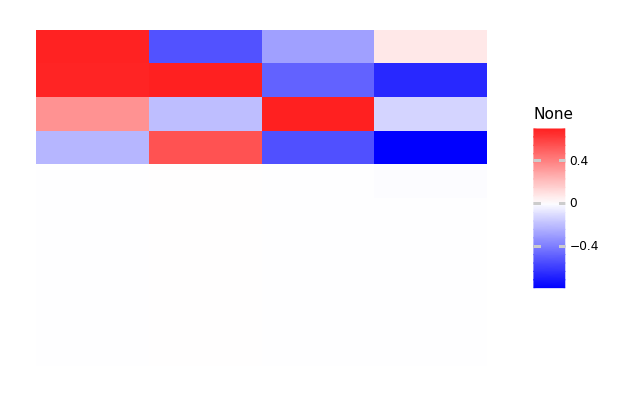

<ggplot: (8745874701305)>

In [13]:
import sklearn.decomposition as decomp
pca = decomp.PCA(10).fit(dataset)
import numpy as np
final_weights = hpc.connection.model.get_weights()
normalized_weights = final_weights[0] / np.linalg.norm(final_weights[0], 2, axis=1, keepdims=True)
contribs = np.matmul(np.linalg.inv(pca.components_).T, normalized_weights.T)
import lazytools_sflippl as lazytools
lazytools.matrix_heatmap(contribs, pole=0)

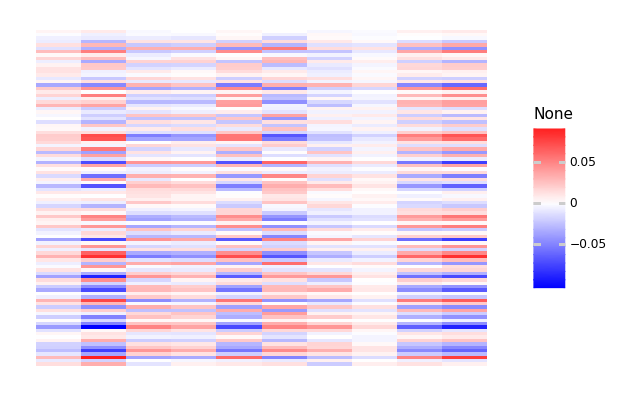

<ggplot: (8755517580561)>

In [14]:
import lazytools_sflippl as lazytools
lazytools.matrix_heatmap(hpc.prediction_error('tier_0').numpy(), pole=0)

In [15]:
hpc._raw_tiers

[<tf.Variable 'hierarchical_1_tier_0:0' shape=(None, 10) dtype=float32, numpy=
 array([[ 0.5180018 , -0.5020392 ,  0.69197327, -0.1109162 ,  0.10659228,
         -0.193478  ,  0.3712293 , -0.13346097, -0.29330575, -0.72092927]],
       dtype=float32)>,
 <tf.Variable 'hierarchical_1_tier_1:0' shape=(None, 4) dtype=float32, numpy=
 array([[-0.96993744, -1.0153694 ,  0.40426496,  0.8733335 ]],
       dtype=float32)>]

What happens if we re-estimate states after every weight improvement?

In [16]:
regimen = pc.regimens.EMRegimen(
    state_regimen=pc.regimens.OptimizerRegimen(
        keras.optimizers.Adam()
    ),
    predictor_regimen=pc.regimens.OptimizerRegimen(
        keras.optimizers.Adam(), max_steps=1, eps=1e-7
    )
)

In [17]:
hpc = pc.Hierarchical(tiers=[(10, ), (4, )])
hpc.connection = pc.connections.TopDownSequential([
    keras.layers.Dense(10, input_shape=(4, ), use_bias=False)
])

Active connection: tier_1 -> tier_0


In [18]:
hpc.compile(optimizer=regimen, metrics=[keras.metrics.MeanSquaredError()])

In [19]:
import tensorflow as tf
import datetime
summary_writer = tf.summary.create_file_writer('log_2/{}'.format(datetime.datetime.now()))

In [20]:
with summary_writer.as_default():
    hpc.train(dataset, epochs=500)

In [21]:
%load_ext tensorboard

In [22]:
%tensorboard --logdir log_2

Reusing TensorBoard on port 6008 (pid 26642), started 0:14:14 ago. (Use '!kill 26642' to kill it.)

In [23]:
import sklearn.decomposition as decomp
pca = decomp.PCA(10).fit(dataset)

In [24]:
hpc.connection.model.get_weights()

[array([[ 0.02783233,  0.4446691 ,  0.10167968,  0.04282278,  0.11785586,
          0.4946642 , -0.46309665, -0.29793537,  0.02711142,  0.37106854],
        [ 0.61379665,  0.13196476,  0.22699323,  0.22479245,  0.11383592,
          0.24530393, -0.42576247,  0.5327278 , -0.25367713, -0.19521189],
        [ 0.33965966, -0.47410136,  0.4208074 ,  0.11683799,  0.76038015,
         -0.12369221,  0.15381712, -0.16772342, -0.33602542,  0.6017772 ],
        [ 0.5172813 ,  0.3608222 , -0.33366346, -0.2662277 ,  0.03994589,
         -0.638896  ,  0.1635841 ,  0.5855882 ,  0.38672897, -0.57893133]],
       dtype=float32)]

In [25]:
import numpy as np
final_weights = hpc.connection.model.get_weights()
normalized_weights = final_weights[0] / np.linalg.norm(final_weights[0], 2, axis=1, keepdims=True)
contribs = np.matmul(np.linalg.inv(pca.components_).T, normalized_weights.T)

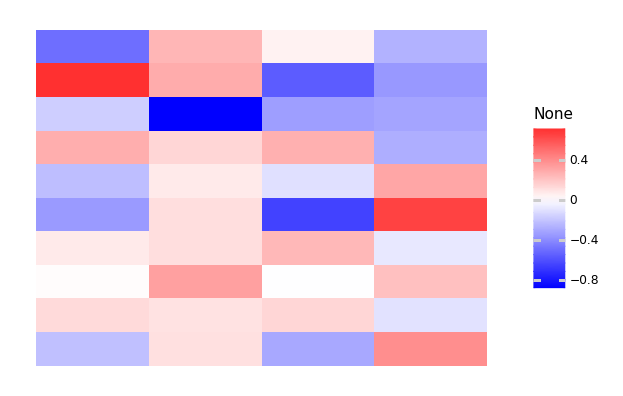

<ggplot: (8755517717985)>

In [26]:
import lazytools_sflippl as lazytools
lazytools.matrix_heatmap(contribs, pole=0)